In [1]:
import pandas as pd
from collections import deque
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint
import time
from sklearn import preprocessing
from keras.utils import to_categorical
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataFiles = [f for f in listdir(os.getcwd()) if '.csv' in f]
dataFiles

['DAT_MT_USDCHF_M1_202101.csv',
 'DAT_MT_GBPUSD_M1_202101.csv',
 'DAT_MT_USDJPY_M1_202101.csv',
 'DAT_MT_EURUSD_M1_202101.csv',
 'DAT_MT_AUDUSD_M1_202101.csv']

In [3]:
#Generic function for data pre processing
dfList = []
for fileName in dataFiles:
    df_name = f'df_{fileName[7:10]}_{fileName[10:13]}'
    dfList.append(df_name)
    globals()[f'{df_name}'] = pd.read_csv(f'./{fileName}',header=None, parse_dates=[[0,1]])
    globals()[f'{df_name}'] = globals()[f'{df_name}'].rename(columns={'0_1':'date-time'})
    globals()[f'{df_name}'].set_index('date-time',inplace=True)
    globals()[f'{df_name}'].drop(columns=[6],inplace=True)
    globals()[f'{df_name}']['currRate'] = globals()[f'{df_name}'].mean(axis=1)
    print('null count in ',df_name,'\n',globals()[f'{df_name}'][globals()[f'{df_name}'].isna()==True].count())
    globals()[f'{df_name}'].drop(columns=[2,3,4,5],inplace=True)
    globals()[f'{df_name}'].rename(columns={'currRate':f'{df_name[3:]}'},inplace=True)

null count in  df_USD_CHF 
 2           0
3           0
4           0
5           0
currRate    0
dtype: int64
null count in  df_GBP_USD 
 2           0
3           0
4           0
5           0
currRate    0
dtype: int64
null count in  df_USD_JPY 
 2           0
3           0
4           0
5           0
currRate    0
dtype: int64
null count in  df_EUR_USD 
 2           0
3           0
4           0
5           0
currRate    0
dtype: int64
null count in  df_AUD_USD 
 2           0
3           0
4           0
5           0
currRate    0
dtype: int64


In [4]:

master_df = globals()[f'{dfList[0]}']
master_df

,USD_CHF
date-time,
2021-01-03 17:00:00,0.883025
2021-01-03 17:01:00,0.882972
2021-01-03 17:02:00,0.883030
2021-01-03 17:03:00,0.883118
2021-01-03 17:04:00,0.883050
...,...
2021-01-31 23:54:00,0.891753
2021-01-31 23:55:00,0.891865
2021-01-31 23:56:00,0.891925


In [5]:
for df_name in dfList[1:]:
    master_df=master_df.join(globals()[f'{df_name}'])

In [6]:
master_df

,USD_CHF,GBP_USD,USD_JPY,EUR_USD,AUD_USD
date-time,,,,,
2021-01-03 17:00:00,0.883025,1.364705,103.12850,1.223900,0.770220
2021-01-03 17:01:00,0.882972,1.364863,103.16075,1.223968,0.770205
2021-01-03 17:02:00,0.883030,1.365012,103.17900,1.223895,0.770205
2021-01-03 17:03:00,0.883118,1.365088,103.18250,1.223832,0.770185
2021-01-03 17:04:00,0.883050,1.365000,103.18975,1.223515,0.769840
...,...,...,...,...,...
2021-01-31 23:54:00,0.891753,1.373200,104.69650,1.212895,0.764950
2021-01-31 23:55:00,0.891865,1.373240,104.69650,1.212857,0.765005
2021-01-31 23:56:00,0.891925,1.373163,104.69775,1.212818,0.764980


In [7]:
master_df['USD_CHF'] = 1/master_df['USD_CHF']
master_df.rename(columns={'USD_CHF':'CHF_USD'},inplace=True)
master_df

,CHF_USD,GBP_USD,USD_JPY,EUR_USD,AUD_USD
date-time,,,,,
2021-01-03 17:00:00,1.132471,1.364705,103.12850,1.223900,0.770220
2021-01-03 17:01:00,1.132538,1.364863,103.16075,1.223968,0.770205
2021-01-03 17:02:00,1.132464,1.365012,103.17900,1.223895,0.770205
2021-01-03 17:03:00,1.132352,1.365088,103.18250,1.223832,0.770185
2021-01-03 17:04:00,1.132439,1.365000,103.18975,1.223515,0.769840
...,...,...,...,...,...
2021-01-31 23:54:00,1.121387,1.373200,104.69650,1.212895,0.764950
2021-01-31 23:55:00,1.121246,1.373240,104.69650,1.212857,0.765005
2021-01-31 23:56:00,1.121171,1.373163,104.69775,1.212818,0.764980


In [8]:
master_df['USD_JPY'] = 1/master_df['USD_JPY']
master_df.rename(columns={'USD_JPY':'JPY_USD'},inplace=True)
master_df

,CHF_USD,GBP_USD,JPY_USD,EUR_USD,AUD_USD
date-time,,,,,
2021-01-03 17:00:00,1.132471,1.364705,0.009697,1.223900,0.770220
2021-01-03 17:01:00,1.132538,1.364863,0.009694,1.223968,0.770205
2021-01-03 17:02:00,1.132464,1.365012,0.009692,1.223895,0.770205
2021-01-03 17:03:00,1.132352,1.365088,0.009692,1.223832,0.770185
2021-01-03 17:04:00,1.132439,1.365000,0.009691,1.223515,0.769840
...,...,...,...,...,...
2021-01-31 23:54:00,1.121387,1.373200,0.009551,1.212895,0.764950
2021-01-31 23:55:00,1.121246,1.373240,0.009551,1.212857,0.765005
2021-01-31 23:56:00,1.121171,1.373163,0.009551,1.212818,0.764980


In [9]:
master_df.to_csv('Master_M1_202101')

#PLOTTING CORRELATION

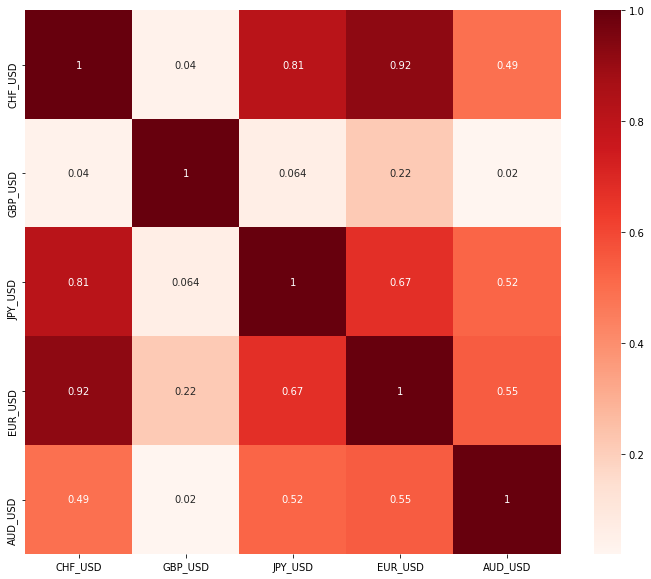

In [10]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = abs(master_df.corr())
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
#Correlation with output variable
#checking for each columns as output variable
for col in master_df:
    cor_target = abs(cor[col])
    print('output :',col)
    print(cor_target[cor_target>0.5])
    print(cor_target.sum())
    print('*'*20)

output : CHF_USD
CHF_USD    1.000000
JPY_USD    0.809827
EUR_USD    0.920081
Name: CHF_USD, dtype: float64
3.262361112900849
********************
output : GBP_USD
GBP_USD    1.0
Name: GBP_USD, dtype: float64
1.3398025119542016
********************
output : JPY_USD
CHF_USD    0.809827
JPY_USD    1.000000
EUR_USD    0.671299
AUD_USD    0.521943
Name: JPY_USD, dtype: float64
3.066633021337221
********************
output : EUR_USD
CHF_USD    0.920081
JPY_USD    0.671299
EUR_USD    1.000000
AUD_USD    0.545847
Name: EUR_USD, dtype: float64
3.353422458657411
********************
output : AUD_USD
JPY_USD    0.521943
EUR_USD    0.545847
AUD_USD    1.000000
Name: AUD_USD, dtype: float64
2.5801940926880724
********************


### Choosing EUR_USD as output column and CHF_USD,JPY_USD,AUD_USD as features

In [14]:
columns = ['CHF_USD','JPY_USD','AUD_USD','EUR_USD']
master_df = master_df[columns]
master_df

,CHF_USD,JPY_USD,AUD_USD,EUR_USD
date-time,,,,
2021-01-03 17:00:00,1.132471,0.009697,0.770220,1.223900
2021-01-03 17:01:00,1.132538,0.009694,0.770205,1.223968
2021-01-03 17:02:00,1.132464,0.009692,0.770205,1.223895
2021-01-03 17:03:00,1.132352,0.009692,0.770185,1.223832
2021-01-03 17:04:00,1.132439,0.009691,0.769840,1.223515
...,...,...,...,...
2021-01-31 23:54:00,1.121387,0.009551,0.764950,1.212895
2021-01-31 23:55:00,1.121246,0.009551,0.765005,1.212857
2021-01-31 23:56:00,1.121171,0.009551,0.764980,1.212818


In [15]:
TRAIN_SEQ_LEN = 70  # How many previous records to gather for LSTM
FORECAST_OFFSET = 2  # how far into the future are we trying to predict?
CCYPAIR_TO_PREDICT = "EUR_USD"
EPOCHS = 4  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{TRAIN_SEQ_LEN}-SEQ-{FORECAST_OFFSET}-PRED-{int(time.time())}"

In [55]:
def classify_trade(curr, fut): # Buy - 1, Sell 0
    if float(fut) > float(curr):  
        return 1 #Buy
    else:  # otherwise... it's a 0!
        return 0 #Sell


In [56]:
master_df['future'] = master_df[f'{CCYPAIR_TO_PREDICT}'].shift(-FORECAST_OFFSET)
master_df['label'] = list(map(classify_trade, master_df[f'{CCYPAIR_TO_PREDICT}'], master_df['future']))

master_df.dropna(inplace=True)


In [61]:
#Number of buy cases and sell cases - roughly equal
master_df.groupby('label').count()

,CHF_USD,JPY_USD,AUD_USD,EUR_USD,future
label,,,,,
0,14374,14374,14374,14374,14374
1,14144,14144,14144,14144,14144


In [62]:
master_df

,CHF_USD,JPY_USD,AUD_USD,EUR_USD,future,label
date-time,,,,,,
2021-01-03 17:00:00,1.132471,0.009697,0.770220,1.223900,1.223895,0
2021-01-03 17:01:00,1.132538,0.009694,0.770205,1.223968,1.223832,0
2021-01-03 17:02:00,1.132464,0.009692,0.770205,1.223895,1.223515,0
2021-01-03 17:03:00,1.132352,0.009692,0.770185,1.223832,1.223202,0
2021-01-03 17:04:00,1.132439,0.009691,0.769840,1.223515,1.223130,0
...,...,...,...,...,...,...
2021-01-31 23:50:00,1.121447,0.009551,0.764965,1.212965,1.212930,0
2021-01-31 23:51:00,1.121419,0.009551,0.764988,1.212938,1.212930,0
2021-01-31 23:52:00,1.121403,0.009551,0.764985,1.212930,1.212895,0


In [72]:
def data_preprocess(df):
    df = df.drop("future", 1)  # Not required for training/testing.

    '''Converting all values to percentage change - as currency rate movement is more indicative than absolute values''' 
    for col in df.columns:  
        if col != "label":  
            df[col] = df[col].pct_change()  
            df.dropna(inplace=True)  
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  


    sequence_data = []  # list to store data sequence for LSTM features
    previous_minutes = deque(maxlen=TRAIN_SEQ_LEN)  
    

    for i in df.values:  # iterate over the values
        previous_minutes.append([n for n in i[:-1]])  # store all except the label column
        if len(previous_minutes) == TRAIN_SEQ_LEN:  
            sequence_data.append([np.array(previous_minutes), i[-1]])  #when sequence length is reached, append 

    random.shuffle(sequence_data)  # shuffle for good measure.

    buy_sequences = []  # list to store our buy sequences and labels
    sell_sequences = []  # list to will store our sell sequences and labels

    for seq, label in sequence_data:  
        if label == 0:  # sell sequence
            sell_sequences.append([seq, label])  
        elif label == 1:  # buy sequence
            buy_sequences.append([seq, label])  

    random.shuffle(buy_sequences)  # shuffle the buys
    random.shuffle(sell_sequences)  # shuffle the sells

    lower = min(len(buy_sequences), len(sell_sequences))  # what's the shorter length?

    #To have equal numbers of buy and sell sequences
    buy_sequences = buy_sequences[:lower]  
    sell_sequences = sell_sequences[:lower]  

    sequence_data = buy_sequences+sell_sequences  # add them together
    random.shuffle(sequence_data)  
    

    X = []
    y = []

    for seq, target in sequence_data:  
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the labels (buy - 1 /sell - 0)

    return np.array(X), y  # return X and y...and make X a numpy array!

In [73]:
## Splitting train and test data
minutes = sorted(master_df.index.values)
last_5pct = sorted(master_df.index.values)[-int(0.05*len(minutes))] #taking the last 5% records for testing

test_master_df = master_df[(master_df.index >= last_5pct)]
master_df = master_df[(master_df.index < last_5pct)]

train_x, train_y = data_preprocess(master_df)
test_x, test_y = data_preprocess(test_master_df)

print(f"train data: {len(train_x)} test: {len(test_x)}")
print(f"TRAIN --> Sells: {train_y.count(0)}, Buys: {train_y.count(1)}")
print(f"TEST --> Sells : {test_y.count(0)}, Buys: {test_y.count(1)}")

model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))


opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
#     loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

train_x = np.asarray(train_x)
train_y = np.asarray(train_y)

test_x = np.asarray(test_x)
test_y = np.asarray(test_y)


# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(test_x, test_y)
#     ,
#     callbacks=[tensorboard, checkpoint],
)

# Score model
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
# Save model
model.save("models/{}".format(NAME))

train data: 20784 test: 1000
TRAIN --> Sells: 10392, Buys: 10392
TEST --> Sells : 500, Buys: 500
Epoch 1/4
325/325 [==============================] - 113s 326ms/step - loss: 0.8418 - accuracy: 0.5001 - val_loss: 0.7000 - val_accuracy: 0.4830
Epoch 2/4
325/325 [==============================] - 100s 308ms/step - loss: 0.7151 - accuracy: 0.5053 - val_loss: 0.6938 - val_accuracy: 0.5100
Epoch 3/4
325/325 [==============================] - 100s 309ms/step - loss: 0.6986 - accuracy: 0.5163 - val_loss: 0.6923 - val_accuracy: 0.5090
Epoch 4/4
325/325 [==============================] - 100s 307ms/step - loss: 0.6901 - accuracy: 0.5400 - val_loss: 0.6931 - val_accuracy: 0.5360
Test loss: 0.6931202411651611
Test accuracy: 0.5360000133514404


INFO:tensorflow:Assets written to: models/70-SEQ-2-PRED-1624173851/assets


INFO:tensorflow:Assets written to: models/70-SEQ-2-PRED-1624173851/assets


In [86]:
def preprocess_x_predict(df):
    df = df.drop("future", 1)  # Not required for training/testing.

    '''Converting all values to percentage change - as currency rate movement is more indicative than absolute values''' 
    for col in df.columns:  
        if col != "label":  
            df[col] = df[col].pct_change()  
            df.dropna(inplace=True)  
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.

    df.dropna(inplace=True)  


    sequence_data = []  # list to store data sequence for LSTM features
    previous_minutes = deque(maxlen=TRAIN_SEQ_LEN)  
    

    for i in df.values:  # iterate over the values
        previous_minutes.append([n for n in i[:-1]])  # store all except the label column
        if len(previous_minutes) == TRAIN_SEQ_LEN:  
            sequence_data.append([np.array(previous_minutes), i[-1]])  #when sequence length is reached, append 

   
    

    X = []
    y = []

    for seq, target in sequence_data:  
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the labels (buy - 1 /sell - 0)

    return np.array(X), y  # return X and y...and make X a numpy array!

In [88]:
X_pred, y_test = preprocess_x_predict(test_master_df)